In [6]:
%pip install pyfolio-reloaded

In [7]:
# Selecting libraries
import yfinance as yf
import pandas as pd
from datetime import timedelta, date, datetime
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [8]:
cryptos = ['BTC-USD','ETH-USD', 'FTM-USD', 'SNX-USD']  # Assets to select yfinance format 'MATIC-USD' , 'AVAX-USD'
cryptos_benchmark = ['BTC-USD','ETH-USD', 'FTM-USD', 'SNX-USD']
portfolio_value = 10**6                        # Initial portfolio value to be allocated
portfolio_value_benchmark = 10**6              # Initial portfolio value to be allocated (Buy and Hold)
weights = [0.25, 0.25, 0.25, 0.25]             # Weight allocation per asset
weights_benchmark = [0.25, 0.25, 0.25, 0.25]   # Weight allocation per asset (Buy and Hold)

Rebalance_dates = []
start_date = '2022-01-20'   # Start date for asset data download
live_date = '2023-04-01'    # Portfolio LIVE start date (for analytics)
Rebalance_days = 180        # Rebalance frequency (days)
td = pd.Timedelta(Rebalance_days, "d")
target_weight = 0.3         # Maximum Weight Without Rebalancing
#Staking Rates, Example: APY 10% => 1.1 = 1 + r*365 => r = (1.1 - 1.0)/365 = 0.00027 => deposit increaes by (1+r) every day
#If Staking APY = 0% => r = 0 => (1+r) = 1.0
Restaking_Period = 7        # How often you restake (Ex, every 7 days
Staking_Rewards = [1.00027, 1.00027, 1.00027, 1.00027]

def daterange(date1, date2):
    for n in range(int((((date2 - date1).days)+1)/Rebalance_days)+1):
        yield date1 + td*n
        #print(date1 + td*n)
start_dt = datetime.strptime(start_date,"%Y-%m-%d").date()
#print(start_dt)
end_dt = datetime.strptime(live_date, "%Y-%m-%d").date()
#print(end_dt)
for dt in daterange(start_dt, end_dt):
    dt = dt.strftime('%Y-%m-%d') #    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    Rebalance_dates.append(dt)
#print(Rebalance_dates)

# Warning handling
if len(weights) != len(cryptos):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')

if sum((np.array(weights))) != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')

In [9]:
# Data download (https://finance.yahoo.com/crypto/) - here you cn find ticker and 1st day of trading in hystory
crypto_data = yf.download(cryptos, start=start_date)['Adj Close']
crypto_data_benchmark = yf.download(cryptos_benchmark, start=start_date)['Adj Close']
crypto_data = crypto_data.dropna()
crypto_data_benchmark = crypto_data_benchmark.dropna()
crypto_data = crypto_data.reindex(columns=cryptos) #! Key to mantain structure
crypto_data_benchmark = crypto_data_benchmark.reindex(columns=cryptos_benchmark) #! Key to mantain structure
crypto_prices = crypto_data[cryptos].values
crypto_prices_benchmark = crypto_data_benchmark[cryptos_benchmark].values
crypto_prices_benchmark[0]
crypto_data_benchmark.index = crypto_data_benchmark.index.strftime('%Y-%m-%d')
#crypto_data


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


In [10]:
# Quantity of coins on the 1st day
coins_df = pd.DataFrame(index=[crypto_data.index[0]])

for s,w in zip(cryptos, weights):
    coins_df[s+ '_coins'] = np.floor((portfolio_value * np.array(w)) / crypto_data[s][0]) #+ '_coins'

coins_df

,BTC-USD_coins,ETH-USD_coins,FTM-USD_coins,SNX-USD_coins
2022-01-20,6.0,83.0,91907.0,52410.0


In [11]:
coins_benchmark_df = pd.DataFrame(index=[crypto_data_benchmark.index[0]])

for s,w in zip(cryptos_benchmark, weights):
    coins_benchmark_df[s] = np.floor((portfolio_value_benchmark * np.array(w)) / crypto_data_benchmark[s][0]) #coins_benchmark_df[s + '_coins'] =


In [12]:
from multiprocessing.process import current_process
# REBALANCING ENGINE


# set initial coins quantity on the first day
coins_df.loc[crypto_data.index[0], :] = [((portfolio_value * w) / crypto_data[s][0]) for s,w in zip(cryptos, weights)]

# initialize variables
balance_day = crypto_data.index[0].day
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([coins_df.loc[crypto_data.index[0], s + '_coins'] * crypto_data.loc[crypto_data.index[0], s] for s in cryptos])
#print(crypto_data.index[0])
current_weights = weights
for day in crypto_data.index:
    if day.date() == crypto_data.index[0].replace(tzinfo=None):
        coins_df.loc[day] = coins_df.loc[day] # First day

        # Store initial values as previous values
        for col in coins_df.columns:
            prev_values[col] = coins_df.loc[day, col]


    elif day.replace(tzinfo=None).strftime('%Y-%m-%d') in Rebalance_dates:
        signal = True
        # calculate new coins based on the new portfolio value and weights
        new_coins = [((portfolio_value * w) / crypto_data[s][day]) for s,w in zip(cryptos, weights)] # np.floor
        coins_df.loc[day, :] = new_coins
        #count += 1
        #print(f'Rebalance: {day.date()}, count: {count}') # uncomment to debug days
        # Store new values as previous values
        for col in coins_df.columns:
            prev_values[col] = coins_df.loc[day, col]
            #print(coins_df.values)


    elif max(weights_current) > target_weight:
        signal = True
        # calculate new coins based on the new portfolio value and weights
        new_coins = [((portfolio_value * w) / crypto_data[s][day]) for s,w in zip(cryptos, weights)]
        coins_df.loc[day, :] = new_coins
        #count += 1
        #print(f'Rebalance: {day.date()}, count: {count}') # uncomment to debug days
        #Store new values as previous values
        for col in coins_df.columns:
            prev_values[col] = coins_df.loc[day, col]

    else:

        signal = False
        # Use previous values if it is not a rebalancing date
        Staking_Rewards_Adjusted = Staking_Rewards
        def Staking_Rewards_Adjuster(count):
         if count != 0 and count % Restaking_Period == 0:
            Staking_Rewards_Adjusted = (np.array(Staking_Rewards) - np.array(Staking_Rewards)/np.array(Staking_Rewards)) * Restaking_Period + np.array(Staking_Rewards)/np.array(Staking_Rewards)
         else:
            Staking_Rewards_Adjusted = np.array(Staking_Rewards) / np.array(Staking_Rewards)
         return Staking_Rewards_Adjusted
        Staking_Rewards_Adjusted = (Staking_Rewards_Adjuster(count))
        new_coins = np.array([prev_values[col] for col in coins_df.columns])* (Staking_Rewards_Adjusted)
        coins_df.loc[day, :] = new_coins
        for col in coins_df.columns:
            prev_values[col] = coins_df.loc[day, col]
            #print(coins_df.values)
        count += 1


    # Calculate asset values and portfolio value for the current day
    asset_values = [coins_df.loc[day, s + '_coins'] * crypto_data.loc[day, s] for s in cryptos]
    portfolio_value = sum(asset_values)
    weights_current = asset_values/portfolio_value
    #print(asset_values, portfolio_value)
    crypto_data.loc[day, 'Signal'] = signal
    crypto_data.loc[day, 'Portfolio_Value'] = portfolio_value

    # Add coins to crypto data frame
    for s in cryptos:
        crypto_data.loc[day, s + '_coins'] = coins_df.loc[day, s + '_coins']
        crypto_data.loc[day, s + '_value'] = coins_df.loc[day, s + '_coins'] * crypto_data.loc[day, s]
#display(crypto_data)
#print(crypto_data)

In [13]:
# Benchmark portfolio
from multiprocessing.process import current_process


for day in crypto_data_benchmark.index:
    asset_values_benchmark = [coins_df.loc[start_date, s + '_coins'] * crypto_data_benchmark.loc[day, s] for s in cryptos]
    #print(asset_values_benchmark)
    portfolio_value_benchmark = sum(asset_values_benchmark)

    crypto_data_benchmark.loc[day, 'Portfolio_Value_Benchmark'] = portfolio_value_benchmark



In [14]:
# Calculate log returns for portfolio
crypto_data['Portfolio_Value_rets'] = np.log(crypto_data['Portfolio_Value'] / crypto_data['Portfolio_Value'].shift(1))

# Calculate log returns for each crypto
for crypto in cryptos:
    crypto_data[f'{crypto}_rets'] = np.log(crypto_data[crypto] / crypto_data[crypto].shift(1))

    #print(crypto_data['Portfolio_Value'])


In [15]:
# Calculate log returns for portfolio_benchmark
crypto_data_benchmark['Benchmark_Portfolio_Value_rets'] = np.log(crypto_data_benchmark['Portfolio_Value_Benchmark'] / crypto_data_benchmark['Portfolio_Value_Benchmark'].shift(1))

# Calculate log returns for each crypto
for crypto in cryptos:
    crypto_data_benchmark[f'{crypto}_rets'] = np.log(crypto_data_benchmark[crypto] / crypto_data_benchmark[crypto].shift(1))


In [16]:
start_date_benchmark = crypto_data_benchmark.index[0]
crypto_data_benchmark = crypto_data_benchmark.dropna()

In [17]:
# Calculate daily weight per asset
for s in cryptos:
    crypto_data[s + '_weight'] = crypto_data[s + '_value'] / crypto_data['Portfolio_Value']

In [18]:
crypto_data.filter(regex='weight')

,BTC-USD_weight,ETH-USD_weight,FTM-USD_weight,SNX-USD_weight
Date,,,,
2022-01-20,0.250000,0.250000,0.250000,0.250000
2022-01-21,0.258918,0.246246,0.242030,0.252806
2022-01-22,0.271430,0.252618,0.227233,0.248719
2022-01-23,0.262408,0.248562,0.246888,0.242142
2022-01-24,0.263199,0.237527,0.242207,0.257067
...,...,...,...,...
2023-08-06,0.262004,0.260610,0.248421,0.228964
2023-08-07,0.264592,0.261858,0.245505,0.228046
2023-08-08,0.264800,0.260974,0.245245,0.228981


In [19]:
fig = go.Figure()
# Loop through each crypto and add a trace for its coins
for crypto in cryptos:
    fig.add_trace(go.Scatter(x=crypto_data.index, y=coins_df[crypto+'_coins'], mode='lines', name=crypto+'_coins'))

fig.update_layout(title='Coins per day',
                  xaxis_title='Date',
                  yaxis_title='Coins',
                  width=800,
                  height=400)

In [20]:
fig = go.Figure()

# Loop through each crypto and add a trace for its coins
for crypto in cryptos:
    fig.add_trace(go.Scatter(x=crypto_data.index, y=crypto_data[crypto + '_weight'], mode='lines', name=crypto + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

In [21]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Coins Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=crypto_data.index, y=crypto_data['Portfolio_Value'], name='Portfolio'), row=1, col=1)
fig.add_trace(go.Scatter(x=crypto_data.index, y=crypto_data_benchmark['Portfolio_Value_Benchmark'], name='Buy&Hold'), row=1, col=1)

for s in cryptos:
    fig.add_trace(go.Scatter(x=crypto_data.index, y=crypto_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2) #Benchmark_
    fig.add_trace(go.Scatter(x=coins_df.index, y=coins_df[f'{s}_coins'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=crypto_data.index, y=crypto_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()

In [22]:
# Data timezone unification for pyfolio valuation
crypto_data.index = crypto_data.index.tz_localize('UTC')
live_date = pd.Timestamp(live_date, tz='UTC')

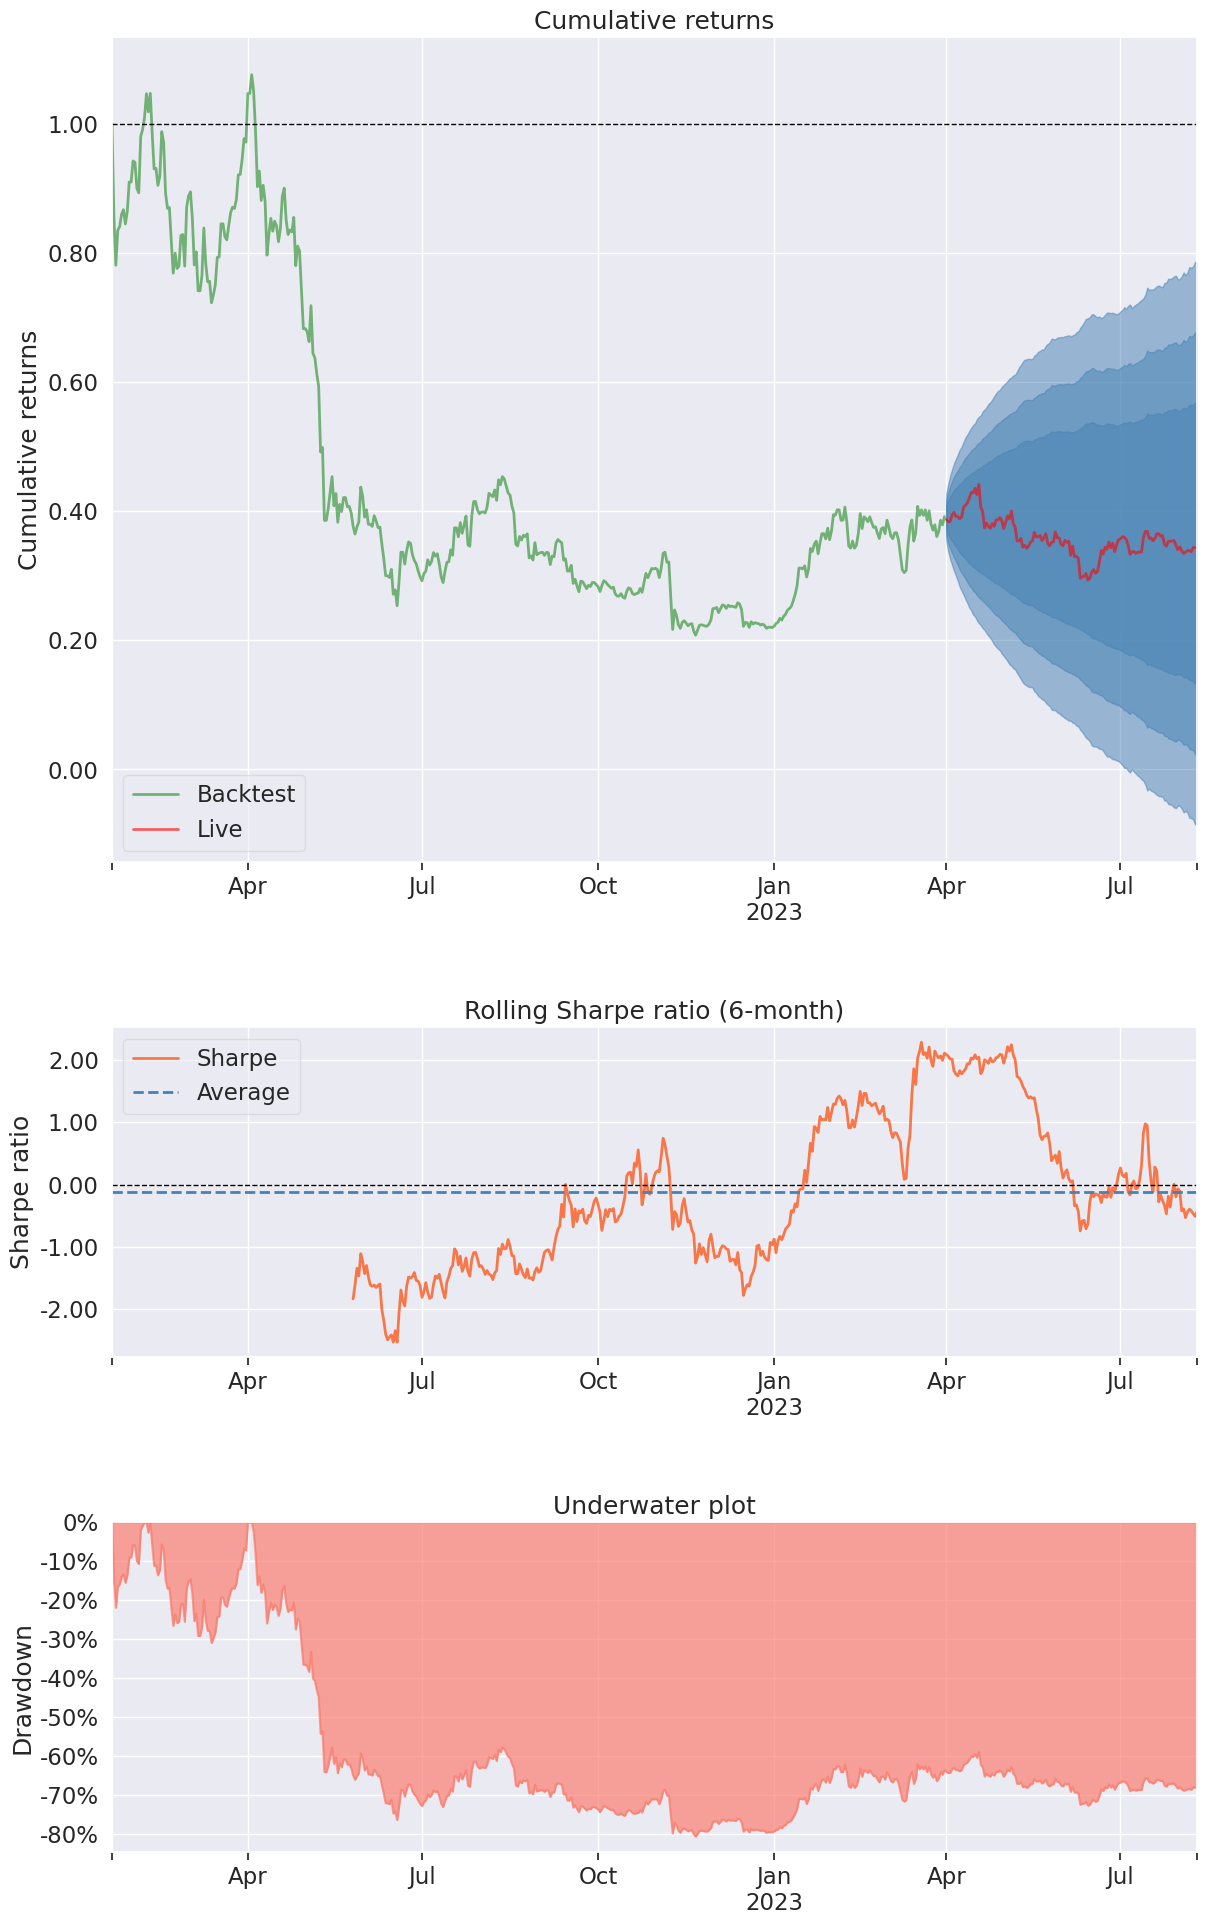

In [23]:
py.create_simple_tear_sheet(crypto_data['Portfolio_Value_rets'], live_start_date = live_date)